In [1]:
# Imports

import os
import copy
import time
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
from skimage.segmentation import flood, flood_fill
from scipy import stats

In [2]:
# Visualize Functions

cmap = colors.ListedColormap(
    ['#FFFFFF','#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=-1, vmax=9)

def getData(task_filename):
    with open(task_filename, 'r') as f:
        task = json.load(f)
    return task

def plotOne(ax, input_matrix, title_text):
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title_text)

def plotTask(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    num_test = len(task['test'])
    num_tot = num_train + num_test
    fig, axs = plt.subplots(2, num_tot, figsize=(3*num_tot,3*2))
    for i in range(num_train):
        plotOne(axs[0,i],task['train'][i]['input'],'train input')
        plotOne(axs[1,i],task['train'][i]['output'],'train output')
    i+=1
    for j in range(num_test):
        plotOne(axs[0,i+j],task['test'][j]['input'],'test input')
        plotOne(axs[1,i+j],task['test'][j]['output'],'test output')  
    plt.tight_layout()
    plt.show()
    
def plotGrid(grid):
    fig = plt.figure(tight_layout=True)
    ax = fig.add_subplot(111)
    plotOne(ax, grid, '')

In [3]:
# Path Definitions

dataset_path = Path('/home/matthew/Programming/ARC/data')
training_path = dataset_path / 'training'
evaluation_path = dataset_path / 'evaluation'
test_path = dataset_path / 'test'

training_tasks = sorted(glob(str(training_path / '*')))
evaluation_tasks = sorted(glob(str(evaluation_path / '*')))
test_tasks = sorted(glob(str(test_path / '*')))

In [4]:
# Image -> List

def splitScenes(pixmap):
    def checkSplit(a, b, center):
        min_col = np.min(center)
        max_col = np.max(center)
        if min_col == max_col:
            return [a, b]
        else:
            return []
    
    x,y = pixmap.shape
    scenes = []
    
    if x % 2 != 0:
        center_idx = int((x-1)/2)
        center = pixmap[center_idx]
        a, b = pixmap[:center_idx], pixmap[center_idx+1:]
        scenes = checkSplit(a,b,center)
    
    if y % 2 != 0:
        center_idx = int((y-1)/2)
        center = pixmap[:,center_idx]
        if len(scenes) > 0:
            all_scenes = []
            for s in scenes:
                a, b = s[:,:center_idx], s[:,center_idx+1:]
                all_scenes.extend(checkSplit(a,b,center))
            scenes = all_scenes
        else:
            a, b = pixmap[:,:center_idx], pixmap[:,center_idx+1:]
            scenes = checkSplit(a,b,center)
    
    if len(scenes) == 0: return False
    
    return scenes     

def groupByColor(pixmap):
    """ Split an image into a collection of images with unique color """
    # Count the number of colors
    nb_colors = int(pixmap.max()) + 1
    # Create a pixmap for each color
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    # Filter out empty images
    return [x for x in splited if np.any(x)]

def groupByContact(pixmap):
    pixmap_mask = np.where(pixmap == 0, pixmap, 1)
    passed_coords = []
    splited = []
    x,y = pixmap.shape
    for i in range(x):
        for j in range(y):
            if (i,j) in passed_coords: continue
            filled = flood_fill(pixmap_mask, (i,j), -1, connectivity=1)
            object_coords = np.where(filled == -1)
            passed_coords.extend(list(zip(*object_coords)))
            obj_pixmap = np.zeros((x,y))
            obj_pixmap[object_coords] = pixmap[object_coords]
            splited.append(obj_pixmap)
    return [x for x in splited if np.any(x)]

def selectSingle(pixmap):
    l = groupByContact(pixmap)
    s = [np.sum(i.astype(np.bool)) for i in l]
    l = [i for idx,i in enumerate(l) if s[idx] == 1]
    if len(l) == 0: return False
    return l

def listify(args):
    return list(args)

# def applyToList(l,fn):
#     return [item for sublist in map(fn,l) for item in sublist]

# def applyToList2(l,fn):
#     return list(map(fn,l))

In [5]:
# List -> List

def sortByArea(l):
    s = [np.sum(i.astype(np.bool)) for i in l]
    return [l[i] for _,i in sorted(zip(s,range(len(l))))]

def sortByColor(l):
    s = [np.max(i) for i in l]
    l = [l[i] for _,i in sorted(zip(s,range(len(l))))]
    mode = stats.mode(s)[0]
    if len(mode) > 0:
        if np.max(l[-1]) == mode[0]:
            l = l[::-1]
    return l

def pushUnique(l):
    h = [''.join(list(a.flatten().astype('str'))) for a in l] # Create hash
    S = list(set(h)) # Get unique hashes
    if len(S) < 2: return l
    c = [h.count(i) for i in S] # Get count
    hash2c = {i: j for i,j in zip(S,c)}
    s = [hash2c[i] for i in h] # Create sort
    return [l[i] for _,i in sorted(zip(s,range(len(l))))][::-1] # Reverse by default to push towards tail

def templateColor(l):
    matched = []
    template = tail(l)
    templateShape = template[np.where(template > 0)]
    for i in l[:-1]:
        probeIdx = np.where(i > 0)
        probeShape = i[probeIdx]
        if probeShape.shape == templateShape.shape:
            i[probeIdx] = templateShape
        matched.append(i)
    matched.append(template)
    return matched

In [6]:
# List -> Image

def tail(l):
    return l[-1]

def reverse(l):
    return l[::-1]

def collapse(l):
    pixmap = np.zeros(l[0].shape)
    for i in l:
        pixmap = np.where(i > 0, i, pixmap)
    return pixmap

def stackV(l):
    return np.vstack(l)

def stackH(l):
    v = np.hstack(l)
    return v

def logicAnd(args):
#     g0,g1 = args
#     return np.logical_and(g0,g1) * g0
    return np.logical_and.reduce(tuple(args)) * args[0]

In [7]:
# Image -> Image

def transpose(pixmap):
    x,y = pixmap.shape
    if x != y: return False
    return pixmap.T

def identity(pixmap):
    return pixmap

def connectObject(pixmap):
    coords = np.stack(np.where(pixmap > 0))
    color = np.max(pixmap)
    idx = np.array([np.min(coords,axis=1),np.max(coords,axis=1)])
    pixmap[idx[0,0]:idx[1,0]+1,idx[0,1]:idx[1,1]+1] = color
    return pixmap

def inverse(pixmap):
    negative = np.logical_not(pixmap).astype(int)
    color = max(pixmap.max(), 1)
    return negative * color

def recolor(pixmap,color):
    return pixmap.astype(np.bool) * color

def color0(pixmap):
    return recolor(pixmap,0)

def color1(pixmap):
    return recolor(pixmap,1)

def color2(pixmap):
    return recolor(pixmap,2)

def color3(pixmap):
    return recolor(pixmap,3)

def color4(pixmap):
    return recolor(pixmap,4)

def color5(pixmap):
    return recolor(pixmap,5)

def color6(pixmap):
    return recolor(pixmap,6)

def color7(pixmap):
    return recolor(pixmap,7)

def color8(pixmap):
    return recolor(pixmap,8)

def color9(pixmap):
    return recolor(pixmap,9)

def dropColor(pixmap,color):
    return np.where(pixmap == color, 0, pixmap)

def drop0(pixmap):
    return dropColor(pixmap,0)

def drop1(pixmap):
    return dropColor(pixmap,1)

def drop2(pixmap):
    return dropColor(pixmap,2)

def drop3(pixmap):
    return dropColor(pixmap,3)

def drop4(pixmap):
    return dropColor(pixmap,4)

def drop5(pixmap):
    return dropColor(pixmap,5)

def drop6(pixmap):
    return dropColor(pixmap,6)

def drop7(pixmap):
    return dropColor(pixmap,7)

def drop8(pixmap):
    return dropColor(pixmap,8)

def drop9(pixmap):
    return dropColor(pixmap,9)

def fillColor(pixmap,color):
    return np.where(pixmap == 0, color, pixmap)

def fill0(pixmap):
    return fillColor(pixmap,0)

def fill1(pixmap):
    return fillColor(pixmap,1)

def fill2(pixmap):
    return fillColor(pixmap,2)

def fill3(pixmap):
    return fillColor(pixmap,3)

def fill4(pixmap):
    return fillColor(pixmap,4)

def fill5(pixmap):
    return fillColor(pixmap,5)

def fill6(pixmap):
    return fillColor(pixmap,6)

def fill7(pixmap):
    return fillColor(pixmap,7)

def fill8(pixmap):
    return fillColor(pixmap,8)

def fill9(pixmap):
    return fillColor(pixmap,9)

def moveObjectCenter(pixmap,center):
    coords = np.stack(np.where(pixmap > 0))
    idx = np.array([np.min(coords,axis=1),np.max(coords,axis=1)])
    print(idx)
    
def cropToContent(pixmap):
    # Op argwhere will give us the coordinates of every non-zero point
    true_points = np.argwhere(pixmap)
    if len(true_points) == 0:
        return False
    # Take the smallest points and use them as the top left of our crop
    top_left = true_points.min(axis=0)
    # Take the largest points and use them as the bottom right of our crop
    bottom_right = true_points.max(axis=0)
    # Crop inside the defined rectangle
    pixmap = pixmap[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
    return pixmap

def pushRight(pixmap):
    x,y = pixmap.shape
    outmap = np.zeros((x,y))
    for i in range(x):
        pixels = np.where(pixmap[i,:] > 0)[0]
        num_pixels = len(pixels)
        if num_pixels == 0: continue
        outmap[i,-num_pixels:] = pixmap[i,pixels]
    return outmap

def pushDown(pixmap):
    x,y = pixmap.shape
    outmap = np.zeros((x,y))
    for j in range(y):
        pixels = np.where(pixmap[:,j] > 0)[0]
        num_pixels = len(pixels)
        if num_pixels == 0: continue
        outmap[-num_pixels:,j] = pixmap[pixels,j]
    return outmap

def flipV(pixmap):
    return np.flip(pixmap,axis=0)

def flipH(pixmap):
    return np.flip(pixmap,axis=1)

def scale(args):
    pixmap,factor = args
    return np.kron(pixmap, np.ones((factor,factor)))

def scaleDouble(pixmap):
    return scale((pixmap,2))

def scaleTriple(pixmap):
    return scale((pixmap,3))

def tileV(pixmap):
    return np.tile(pixmap, (3, 1))

def tileH(pixmap):
    return np.tile(pixmap, (1, 3))


# 90c28cc7.json
# def topologicalEquivalence(pixmap):
#     l = groupByColor(pixmap)
#     for li in l:
#         for ji in l:
#             if li == ji: continue
            

# def findPattern(pixmap):
    

In [8]:
# Property -> Image

def eye(args):
    size,color = args
    return np.eye(size) * color

In [9]:
# Image -> Property

def getHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2**i for i in range(len(flat))])
    return np.sum(flat * mult)

def maxColor(pixmap):
    return np.max(pixmap)

def numColor(pixmap):
    colors = list(set(pixmap.flatten()))
    colors.remove(0)
    return len(colors)

In [10]:
# Color Map Functions

def checkColorMap(task):
    c = 1
    for example in task['train']:
        inp = np.array(example['input'])
        out = np.array(example['output'])
        a = sorted(list(map(getHash,groupByColor(inp))))
        b = sorted(list(map(getHash,groupByColor(out))))
        c *= a == b
    return bool(c)

def findColorMap(task):
    colormap = {}
    for example in task['train']:
        inp = np.array(example['input']).flatten()
        out = np.array(example['output']).flatten()
        for col, idx in zip(*np.unique(inp,return_index=True)):
            if col in colormap.keys(): continue
            colormap[col] = out[idx]
    return colormap

def applyColorMap(pixmap, colormap):
    return np.vectorize(colormap.__getitem__)(pixmap)

def flattenPred(pred):
    return str(pred.astype(np.int)) \
                   .replace(' ','') \
                   .replace('[[','|') \
                   .replace(']\n[','|') \
                   .replace(']]','|')

def plotTest(t_in, t_out, t_pred):
    fig, axs = plt.subplots(3, 1, figsize=(4*n,12), dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    axs[0].imshow(t_in, cmap=cmap, norm=norm)
    axs[0].set_title(f'Test-{i} in')
    axs[0].set_yticks(list(range(t_in.shape[0])))
    axs[0].set_xticks(list(range(t_in.shape[1])))
    axs[1].imshow(t_out, cmap=cmap, norm=norm)
    axs[1].set_title(f'Test-{i} out')
    axs[1].set_yticks(list(range(t_out.shape[0])))
    axs[1].set_xticks(list(range(t_out.shape[1])))
    axs[2].imshow(t_pred, cmap=cmap, norm=norm)
    axs[2].set_title(f'Test-{i} pred')
    axs[2].set_yticks(list(range(t_pred.shape[0])))
    axs[2].set_xticks(list(range(t_pred.shape[1])))

# task_id = training_path / 'b1948b0a.json'
# task = getData(task_id)
# # checkColorMap(task)
# colormap = findColorMap(task)
# test = np.array(task['test'][0]['input'])
# plotTask(task)
# plotGrid(applyColorMap(test,colormap))

# submission = pd.read_csv(dataset_path / 'sample_submission.csv')
# test_tasks = submission['output_id'].values

# predictions = []
# for output_id in test_tasks:
#     task_id, grid_id = output_id.split('_')
#     task_id = test_path / ('%s.json' % task_id)
#     task = getData(task_id)
#     if checkColorMap(task):
#         colormap = findColorMap(task)
#         test_in = np.array(task['test'][output_id]['input'])
#         test_out = np.array(task['test'][output_id]['output'])
#         pred = applyColorMap(test_in,colormap)
#         plotTest(test_in,test_out,pred)
#         #correct = np.array_equal(pred,test_out)
#     else:
#         pred = np.zeros((1,1))
#     predictions.append(flattenPred(pred))

# submission["output"] = predictions
# submission.head()
# submission.to_csv('submission.csv', index=False)

In [11]:
# Move Collections

imageMoves = [transpose,
              flipH,flipV,
              pushRight,pushDown,
              inverse,
              cropToContent]

startMoves = [selectSingle,
              splitScenes,
              groupByContact,
              groupByColor]

colorMoves = [color0,color1,color2,color3,color4,color5,color6,color7,color8,color9]

dropColorMoves = [drop0,drop1,drop2,drop3,drop4,drop5,drop6,drop7,drop8,drop9]

fillColorMoves = [fill0,fill1,fill2,fill3,fill4,fill5,fill6,fill7,fill8,fill9]

listMoves = [sortByColor,
             sortByArea,
             pushUnique,
             templateColor,
             collapse,
             logicAnd,
             stackV,
             stackH,]

propMoves = [] #eye

useOnceMoves = [selectSingle,splitScenes,groupByContact,groupByColor,stackV,stackH,templateColor,
                pushUnique,sortByColor,sortByArea,cropToContent,
                drop0,drop1,drop2,drop3,drop4,drop5,drop6,drop7,drop8,drop9,
                fill0,fill1,fill2,fill3,fill4,fill5,fill6,fill7,fill8,fill9]


fn_to_output = {
    selectSingle   : 'list',
    splitScenes    : 'list',
    groupByContact : 'list',
    templateColor  : 'list',
    groupByColor   : 'list',
    selectSingle   : 'list',
    sortByColor    : 'list',
    sortByArea     : 'list',
    reverse        : 'list',
    pushUnique     : 'list',
    listify        : 'list',
    color0         : 'image', color2 : 'image', color4 : 'image', color6 : 'image', color8 : 'image',
    color1         : 'image', color3 : 'image', color5 : 'image', color7 : 'image', color9 : 'image',
    drop0          : 'image', drop2  : 'image', drop4  : 'image', drop6  : 'image', drop8  : 'image',
    drop1          : 'image', drop3  : 'image', drop5  : 'image', drop7  : 'image', drop9  : 'image',
    fill0          : 'image', fill2  : 'image', fill4  : 'image', fill6  : 'image', fill8  : 'image',
    fill1          : 'image', fill3  : 'image', fill5  : 'image', fill7  : 'image', fill9  : 'image',
    identity       : 'image',
    transpose      : 'image',
    scale          : 'image',
    scaleTriple    : 'image',
    scaleDouble    : 'image',
    pushRight      : 'image',
    pushDown       : 'image',
    tileV          : 'image',
    tileH          : 'image',
    inverse        : 'image',
    flipV          : 'image',
    flipH          : 'image',
    stackV         : 'image',
    stackH         : 'image',
    eye            : 'image',
    collapse       : 'image',
    logicAnd       : 'image',
    tail           : 'image',
    cropToContent  : 'image',
    len            : 'prop',
    maxColor       : 'prop',
    numColor       : 'prop'
}

fn_to_idx = { key : idx for idx,key in enumerate(fn_to_output.keys())}

/home/matthew/Programming/ARC/data/training/a3df8b1e.json


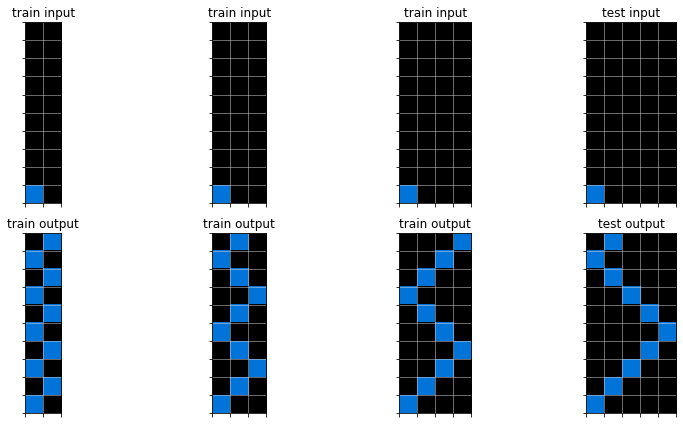

NameError: name 'getImageMoves' is not defined

In [12]:
# View Tasks

def viewRandomTask():
    task_id = np.random.choice(training_tasks)
    print(task_id)
    task = getData(task_id)
    plotTask(task)
    imageMovesP = getImageMoves(task)
    solutionSearch(task)
    
viewRandomTask()
    
# 3de23699.json
# Write function to find box corners and crop view to these

In [16]:
# Hard-coded Graphs
c,t = 0,0

task_id = training_path / '74dd1130.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],transpose)
c += G.evaluate()
t += 1

task_id = training_path / 'a416b8f3.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],identity)
G.addNode([0,1],listify)
G.addNode([2],stackH)
c += G.evaluate()
t += 1

task_id = training_path / 'b91ae062.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],numColor)
G.addNode([0,1],scale)
c += G.evaluate()
t += 1

task_id = training_path / 'f25ffba3.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],flipV)
G.addNode([0,1],listify)
G.addNode([2],collapse)
c += G.evaluate()
t += 1

task_id = training_path / '6150a2bd.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],flipV)
G.addNode([1],flipH)
c += G.evaluate()
t += 1

task_id = training_path / '007bbfb7.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],scaleTriple)
G.addNode([0],tileV)
G.addNode([2],tileH)
G.addNode([3,1],logicAnd)
c += G.evaluate()
t += 1

task_id = training_path / 'f2829549.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],splitScenes)
G.addNode([1],collapse)
G.addNode([2],inverse)
G.addNode([3],color3)
c += G.evaluate()
t += 1

task_id = training_path / '7468f01a.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],cropToContent)
G.addNode([1],flipH)
c += G.evaluate()
t += 1

task_id = training_path / 'd0f5fe59.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],groupByContact)
G.addNode([1],len)
G.addNode([0],maxColor)
G.addNode([3,2],eye)
c += G.evaluate()
t += 1

task_id = training_path / 'e76a88a6.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],groupByContact)
G.addNode([1],sortByColor)
G.addNode([2],templateColor)
G.addNode([3],collapse)
c += G.evaluate()
t += 1

task_id = training_path / '2dc579da.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],splitScenes)
G.addNode([1],pushUnique)
G.addNode([2],tail)
c += G.evaluate()
t += 1

task_id = training_path / '6fa7a44f.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],flipV)
G.addNode([0,1],listify)
G.addNode([2],stackV)
c += G.evaluate()
t += 1

task_id = training_path / 'f76d97a5.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],drop5)
G.addNode([1],inverse)
c += G.evaluate()
t += 1

task_id = training_path / 'aedd82e4.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],selectSingle)
G.addNode([1],collapse)
G.addNode([2],color1)
G.addNode([0,3],listify)
G.addNode([4],collapse)
c += G.evaluate()
t += 1

task_id = training_path / 'a61f2674.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],groupByContact)
G.addNode([1],sortByArea)
G.addNode([2],tail)
G.addNode([2],reverse)
G.addNode([4],tail)
G.addNode([3],color1)
G.addNode([5],color2)
G.addNode([6,7],listify)
G.addNode([8],collapse)
c += G.evaluate()
t += 1

task_id = training_path / '9565186b.json'
task = getData(task_id)
G = Graph(task)
G.addNode([0],groupByColor)
G.addNode([1],sortByArea)
G.addNode([2],tail)
G.addNode([3],fill5)
c += G.evaluate()
t += 1

# task_id = training_path / 'cce03e0d.json'
# task = getData(task_id)
# G = Graph()
# G.addNode([0],groupByColor)
# G.addNode([1],pushUnique)
# G.addNode([2],reverse)
# G.addNode([3],tail)
# G.addNode([4],scaleTriple)
# G.addNode([0],tileV)
# G.addNode([6],tileH)
# G.addNode([5,7],logicAnd) # Issue with logicalAnd multiplication
# c += evaluateGraph(G,task)
# t += 1

print(c == t)

TypeError: cannot unpack non-iterable int object

In [20]:
# Old Graph functions

#     def run(self,x):
#         self.x = {0 : x}
#         queue = [0]
#         discovered = [0]
        
#         while len(queue) > 0:
#             v = queue.pop(0)
#             fn = self.X[v]
#             adj = self.getAdjacent(v)
#             parents = [w for w in adj if w in self.x.keys()]
#             if fn:
#                 args = [self.x[w] for w in parents]
#                 if len(args) == 1:
#                     args = args[0]
#                 r = fn(args)
#                 if type(r) == bool:
#                     if not r: continue
#                 self.x[v] = r
#             if v == self.n - 1:
#                 return self.x[self.n - 1]
#             for w in adj:
#                 if w in discovered: continue
#                 discovered.append(w)
#                 queue.append(w)
#             queue.sort()
            
#     def evaluate(self,vis=False,force=False):
#         for example in self.task['train']:
#             input_grid = np.array(example['input'])
#             output_grid = np.array(example['output'])

#             if force:
#                 try:
#                     pred_grid = self.run(input_grid)
#                 except:
#                     return False
#             else:
#                 pred_grid = self.run(input_grid)

#             if vis:
#                 plotGrid(input_grid)
#                 plotGrid(output_grid)
#                 plotGrid(pred_grid)

#             correct = np.array_equal(output_grid, pred_grid)
#             if not correct: return False
#         return True

In [26]:
# Graph and solution search

class Task:
    def __init__(self, task):
        self.train = task['train']
        self.train_n = len(self.train) # Number of train examples
        self.test = task['test']
        self.test_n = len(self.test) # Number of test examples
        self.x = [np.array(ex['input']) for ex in self.train] # Expected output values
        self.y = [np.array(ex['output']) for ex in self.train] # Expected output values
        

class Graph:
    def __init__(self, task, ignore_errors=True):
        self.ignore_errors = ignore_errors
        self.n = 1 # Number of nodes (including input node)
        self.A = np.zeros((self.n,self.n)) # Adjacency Matrix
        self.X = [None] # Function list
        self.O = ['image'] # Types list
        self.V = {idx : [ex]  for idx,ex in enumerate(task.x)} # Saved node values
        self.prune = False # Flag to prune applications with this subgraph
    
    def updateAdjMat(self,c):
        adj = np.zeros((self.n, self.n))
        adj[:-1,:-1] = self.A
        adj[self.n-1,c] = 1
        adj[c,self.n-1] = 1
        self.A = adj
    
    def addNode(self,c,fn):
        self.n += 1
        self.updateAdjMat(c)
        self.X.append(fn)
        self.O.append(fn_to_output[fn])
        v = fn(self.V[0][-1])
        if type(v) == bool or type(v) == None:
            if not v:
                self.prune = True
                return
        self.V[0].append(v)
    
    def getAdjMat(self):
        return self.A
    
    def getAdjacent(self,v):
        return np.where(self.A[v] == 1)[0]
    
    def getHash(self):
        #return '-'.join([str(fn_to_idx[x]) for x in self.X[1:]])
        return '-'.join([x.__name__ for x in self.X[1:]])
    
    def updateValues(self,idx):
        step = len(self.V[idx])
        while step < self.n:
            fn = self.X[step]
            v = fn(self.V[idx][-1])
            if type(v) == bool or type(v) == None:
                if not v:
                    self.prune = True
                    return
            self.V[idx].append(v)
            step += 1
    
    def evaluate(self):
        if self.O[-1] != 'image': return False
        for i in range(self.train_n):
            self.updateValues(i)
            y = self.Y[i]
            y_hat = self.V[i][-1]
            correct = np.array_equal(y,y_hat)
            if not correct: return False
        return True

def solutionSearch(task,return_data=False):
    data = []
    t0 = time.time()
    
    imageMovesP, listMovesP = getImageMoves(task)
    
    G = Graph(task)
    G_hash = G.getHash()
    queue = [G_hash]
    disc = {G_hash : G}
    knowledge = {G_hash : G.lastValue()}
    
    while len(queue) > 0:
        G_hash = queue.pop(0)
        G = disc[G_hash]
#         print(G_hash)
        
        if G.n > 5: continue
        if G.evaluate():
            t1 = time.time()
            print('Time: %.1f seconds' % (t1-t0))
            return G_hash, data
        
        for move in getPossibleMoves(G,imageMovesP,listMovesP):
            G_copy = copy.deepcopy(G)
            t2 = time.time()
            G_copy.addNode([G_copy.n-1],move)
            if G_copy.prune: continue
            G_hash = G_copy.getHash()
            t3 = time.time()
            data.append([G_hash,t3-t2])
            disc[G_hash] = G_copy
            queue.append(G_hash)
        del G
    if return_data: return False, data
    return False

def getPossibleMoves(G,imageMovesP,listMovesP):
    G_hash = G.getHash()
    actions = G.X
    removeMoves = [m for m in actions if m in useOnceMoves]
    imageMovesP = [m for m in imageMovesP if m not in removeMoves]
    listMovesP =  [m for m in listMovesP  if m not in removeMoves]
    last_action = actions[-1]
    
    if G.O[-1] == 'image':
        imageMovesO = imageMovesP
        
        if G.n == 1:
            imageMovesO = startMoves + imageMovesO
        
        l_scale = [scaleTriple,scaleDouble]
        if last_action in l_scale:
            for act in l_scale:
                if act in imageMovesO: imageMovesO.remove(act)
        
        if 'color' in G_hash:
            for act in colorMoves:
                if act in imageMovesO: imageMovesO.remove(act)
        
        return imageMovesO
    
    if G.O[-1] == 'list':
        listMovesO = listMovesP
        
        l_sort = [sortByColor,sortByArea,pushUnique]
        if last_action in l_sort:
            for act in l_sort:
                if act in listMovesO: listMovesO.remove(act)
                
        return listMovesO
    
    if G.O[-1] == 'prop':
        return propMoves
    
def getImageMoves(task):
    scaleMovesP = []
    
    input_grids = [np.array(ex['input']) for ex in task['train']]
    output_grids = [np.array(ex['output']) for ex in task['train']]
    
    input_colors = np.unique(np.hstack([np.unique(grid) for grid in input_grids]))
    output_colors = np.unique(np.hstack([np.unique(grid) for grid in output_grids]))
    in_not_out_colors = [c for c in input_colors if c not in output_colors]
    
    for i,ex in enumerate(task['train']):
        in_grid = input_grids[i]
        out_grid = output_grids[i]
        
        i_in,j_in = in_grid.shape
        i_out,j_out = out_grid.shape
        i_check = i_in < i_out
        j_check = j_in < j_out
        if i_check or j_check:
            scaleMovesP.extend([scaleTriple,scaleDouble])
            if i_check:
                scaleMovesP.append(tileV)
            if j_check:
                scaleMovesP.append(tileH)
        
    colorMovesP = [colorMoves[i] for i in output_colors]
    dropColorMovesP = [dropColorMoves[i] for i in in_not_out_colors]
    if 0 in output_colors:
        fillColorMovesP = []
    else:
        fillColorMovesP = [fillColorMoves[i] for i in output_colors]
    imageMovesP = imageMoves + colorMovesP + scaleMovesP + dropColorMovesP + fillColorMovesP
    listMovesP = listMoves
    return imageMovesP, listMovesP

In [17]:
def optimizeSearch():
    task_id = training_path / '5bd6f4ac.json'
    task = getData(task_id)
    result, data = solutionSearch(task,return_data=True)
    df = pd.DataFrame(data,columns=['graph','time']).sort_values(by='time',ascending=False)
    return df

In [283]:
df = optimizeSearch()

KeyboardInterrupt: 

In [ ]:
df.head(20)

In [31]:
# def summaryTree(data):
    

In [27]:
#transpose
task_id = training_path / '74dd1130.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.0 seconds


('transpose',
 [['groupByContact', 0.0002932548522949219],
  ['groupByColor', 0.00010013580322265625],
  ['transpose', 2.4080276489257812e-05],
  ['flipH', 4.029273986816406e-05],
  ['flipV', 2.86102294921875e-05],
  ['pushRight', 5.936622619628906e-05],
  ['pushDown', 5.245208740234375e-05],
  ['inverse', 4.6253204345703125e-05],
  ['cropToContent', 6.413459777832031e-05],
  ['color1', 3.147125244140625e-05],
  ['color2', 2.8371810913085938e-05],
  ['color5', 3.0040740966796875e-05],
  ['color6', 2.7894973754882812e-05],
  ['color8', 2.6702880859375e-05],
  ['color9', 2.7179718017578125e-05],
  ['fill1', 3.0517578125e-05],
  ['fill2', 2.8133392333984375e-05],
  ['fill5', 2.7894973754882812e-05],
  ['fill6', 2.7418136596679688e-05],
  ['fill8', 2.7418136596679688e-05],
  ['fill9', 2.7418136596679688e-05],
  ['groupByContact-sortByColor', 0.00027441978454589844],
  ['groupByContact-sortByArea', 4.100799560546875e-05],
  ['groupByContact-pushUnique', 5.53131103515625e-05],
  ['groupByCon

In [30]:
task_id = training_path / 'f2829549.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 10.9 seconds


('splitScenes-collapse-inverse-color3',
 [['selectSingle', 0.0014765262603759766],
  ['splitScenes', 5.5789947509765625e-05],
  ['groupByContact', 0.0013606548309326172],
  ['groupByColor', 0.00012111663818359375],
  ['flipH', 3.719329833984375e-05],
  ['flipV', 2.8133392333984375e-05],
  ['pushRight', 6.29425048828125e-05],
  ['pushDown', 7.963180541992188e-05],
  ['inverse', 4.7206878662109375e-05],
  ['cropToContent', 0.00010919570922851562],
  ['color0', 3.981590270996094e-05],
  ['color3', 3.504753112792969e-05],
  ['drop1', 3.647804260253906e-05],
  ['drop5', 3.5762786865234375e-05],
  ['drop7', 3.361701965332031e-05],
  ['selectSingle-sortByColor', 0.0004050731658935547],
  ['selectSingle-sortByArea', 5.078315734863281e-05],
  ['selectSingle-pushUnique', 8.034706115722656e-05],
  ['selectSingle-templateColor', 9.322166442871094e-05],
  ['selectSingle-collapse', 3.933906555175781e-05],
  ['selectSingle-logicAnd', 5.555152893066406e-05],
  ['selectSingle-stackV', 0.000141143798828

In [29]:
task_id = training_path / 'e76a88a6.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 9.0 seconds


('groupByContact-sortByColor-templateColor-collapse',
 [['groupByContact', 0.0019381046295166016],
  ['groupByColor', 9.799003601074219e-05],
  ['transpose', 2.3126602172851562e-05],
  ['flipH', 3.814697265625e-05],
  ['flipV', 2.8133392333984375e-05],
  ['pushRight', 0.00011777877807617188],
  ['pushDown', 0.00010895729064941406],
  ['inverse', 0.00011324882507324219],
  ['cropToContent', 8.320808410644531e-05],
  ['color0', 4.267692565917969e-05],
  ['color2', 3.5762786865234375e-05],
  ['color4', 3.4809112548828125e-05],
  ['color6', 3.504753112792969e-05],
  ['color8', 3.528594970703125e-05],
  ['drop5', 5.817413330078125e-05],
  ['groupByContact-sortByColor', 0.0004482269287109375],
  ['groupByContact-sortByArea', 7.033348083496094e-05],
  ['groupByContact-pushUnique', 0.00023031234741210938],
  ['groupByContact-templateColor', 7.009506225585938e-05],
  ['groupByContact-collapse', 4.57763671875e-05],
  ['groupByContact-logicAnd', 5.698204040527344e-05],
  ['groupByContact-stackV',

In [309]:
task_id = training_path / '7468f01a.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.5 seconds


'flipH-cropToContent'

In [274]:
task_id = training_path / '2dc579da.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 2.6 seconds


'splitScenes-pushUnique-collapse'

In [275]:
task_id = training_path / '6150a2bd.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.2 seconds


'flipH-flipV'

In [276]:
task_id = training_path / '9dfd6313.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.0 seconds


'transpose'

In [311]:
task_id = training_path / 'a740d043.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.4 seconds


'drop1-cropToContent'

In [312]:
task_id = training_path / '1e0a9b12.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.0 seconds


'pushDown'

In [313]:
task_id = training_path / 'f76d97a5.json'
task = getData(task_id)
imageMovesP = getImageMoves(task)
solutionSearch(task)

Time: 0.4 seconds


'drop5-inverse'

In [34]:
# task_id = training_path / 'ae3edfdc.json'
# task = getData(task_id)
# solutionSearch(task)

In [35]:
# df = pd.DataFrame(data, columns=['hash','time'])
# df.sort_values(by='time',ascending=False).reset_index().head(20)

In [1]:
def evaluateDataset(dataset_tasks):
    c,t = 0,0
    for task_id in dataset_tasks:
        task = getData(task_id)
#         plotTask(task)
        imageMovesP = getImageMoves(task)
        solution = solutionSearch(task)
        if solution:
            print(solution)
            print('Success %s' % task_id)
            c += 1
        else:
            print('Failure %s' % task_id)
        t += 1
    print('%d/%d (%.2f)' % (c,t,c/t))

In [ ]:
evaluateDataset(evaluation_tasks)